In [1]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 100)

In [2]:
from pymongo import MongoClient
client = MongoClient()
client = MongoClient('localhost', 27017)

In [3]:
db = client.adsE_database
collection = db.adsE_collection

### prepare data for prediction ###

In [4]:
dictlis = [{'element':'Cu', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Cu', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Ag', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Ag', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Pt', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Pt', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
#            {'element':'NiGa', 'mirror':'110', 'moved+':'no', 'moved':'no'},
#            {'element':'CoPt3', 'mirror':'100', 'moved+':'no', 'moved':'no'},
           {'element':'Pd', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Pd', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Au', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Au', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Al', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Al', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Ni', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Ni', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Rh', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Rh', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Ru', 'mirror':'000', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Zn', 'mirror':'000', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
          ]

In [5]:
results = []
for dic in dictlis:
    tmp = []
    for post in collection.find(dic):
        tmp.append(post)
    results.append(tmp)

df = []
dfpred = []

for i in range(len(results)):
    df.append(pd.DataFrame(results[i]))
    dfpred.append(df[i][df[i]['numberofads'] > 1])

for i in range(len(dfpred)):
    dfpred[i] = dfpred[i].reset_index()

In [6]:
### Exclude coverage > 1.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['coverage'] <= 1.0]
    
### Exclude ads ene > 2.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['aveadsEne/suratom'] >= -2.0]

In [7]:
covset = []
for i in range(len(df)):
    covset.append(sorted(list(set(dfpred[i]['coverage']))))
covset

[[0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75]]

### Predict ####

In [8]:
def predE(ele_mir, dfele, COinteractionflag ,CObondlengthflag):
    name = dfele['name']
    res = re.match('(.*u\d).*', name)
    barefile = res.group(1) + '.traj'
    bareatoms = query(barefile, 'spacom')
    slabE = bareatoms.get_potential_energy()
    
    igroups = dfele['igroups']
    adsElis = [] # adsE + slabE
    COEdifflis = []
    a2 = 46.252
    a1 = -106.43
    a0 = 46.754
    def COene(COlen):
        return a2*COlen**2 + a1*COlen + a0

    for i in range(len(igroups)):
        tmp = []
        tmp.append(igroups[i])
        try:
            adsE = df[ele_mir][(df[ele_mir]['unitlength']==dfele['unitlength'])&
                             (df[ele_mir]['numberofads']==1)&
                             (df[ele_mir]['igroups'].apply(lambda x: x==tmp))]['totaladsEnergy']
            adsElis.append(float(adsE))
        except:
#             print(name, 'One adsorbate result not found')
            return None
            
    Eint = dfele['ECO_Eint'] - COene(1.148)*dfele['numberofads']
    preadsdene = sum(adsElis)
    if COinteractionflag:
        preadsdene += Eint

    predadsene_surf = preadsdene/dfele['surfatomnum']

    return predadsene_surf, adsElis, Eint

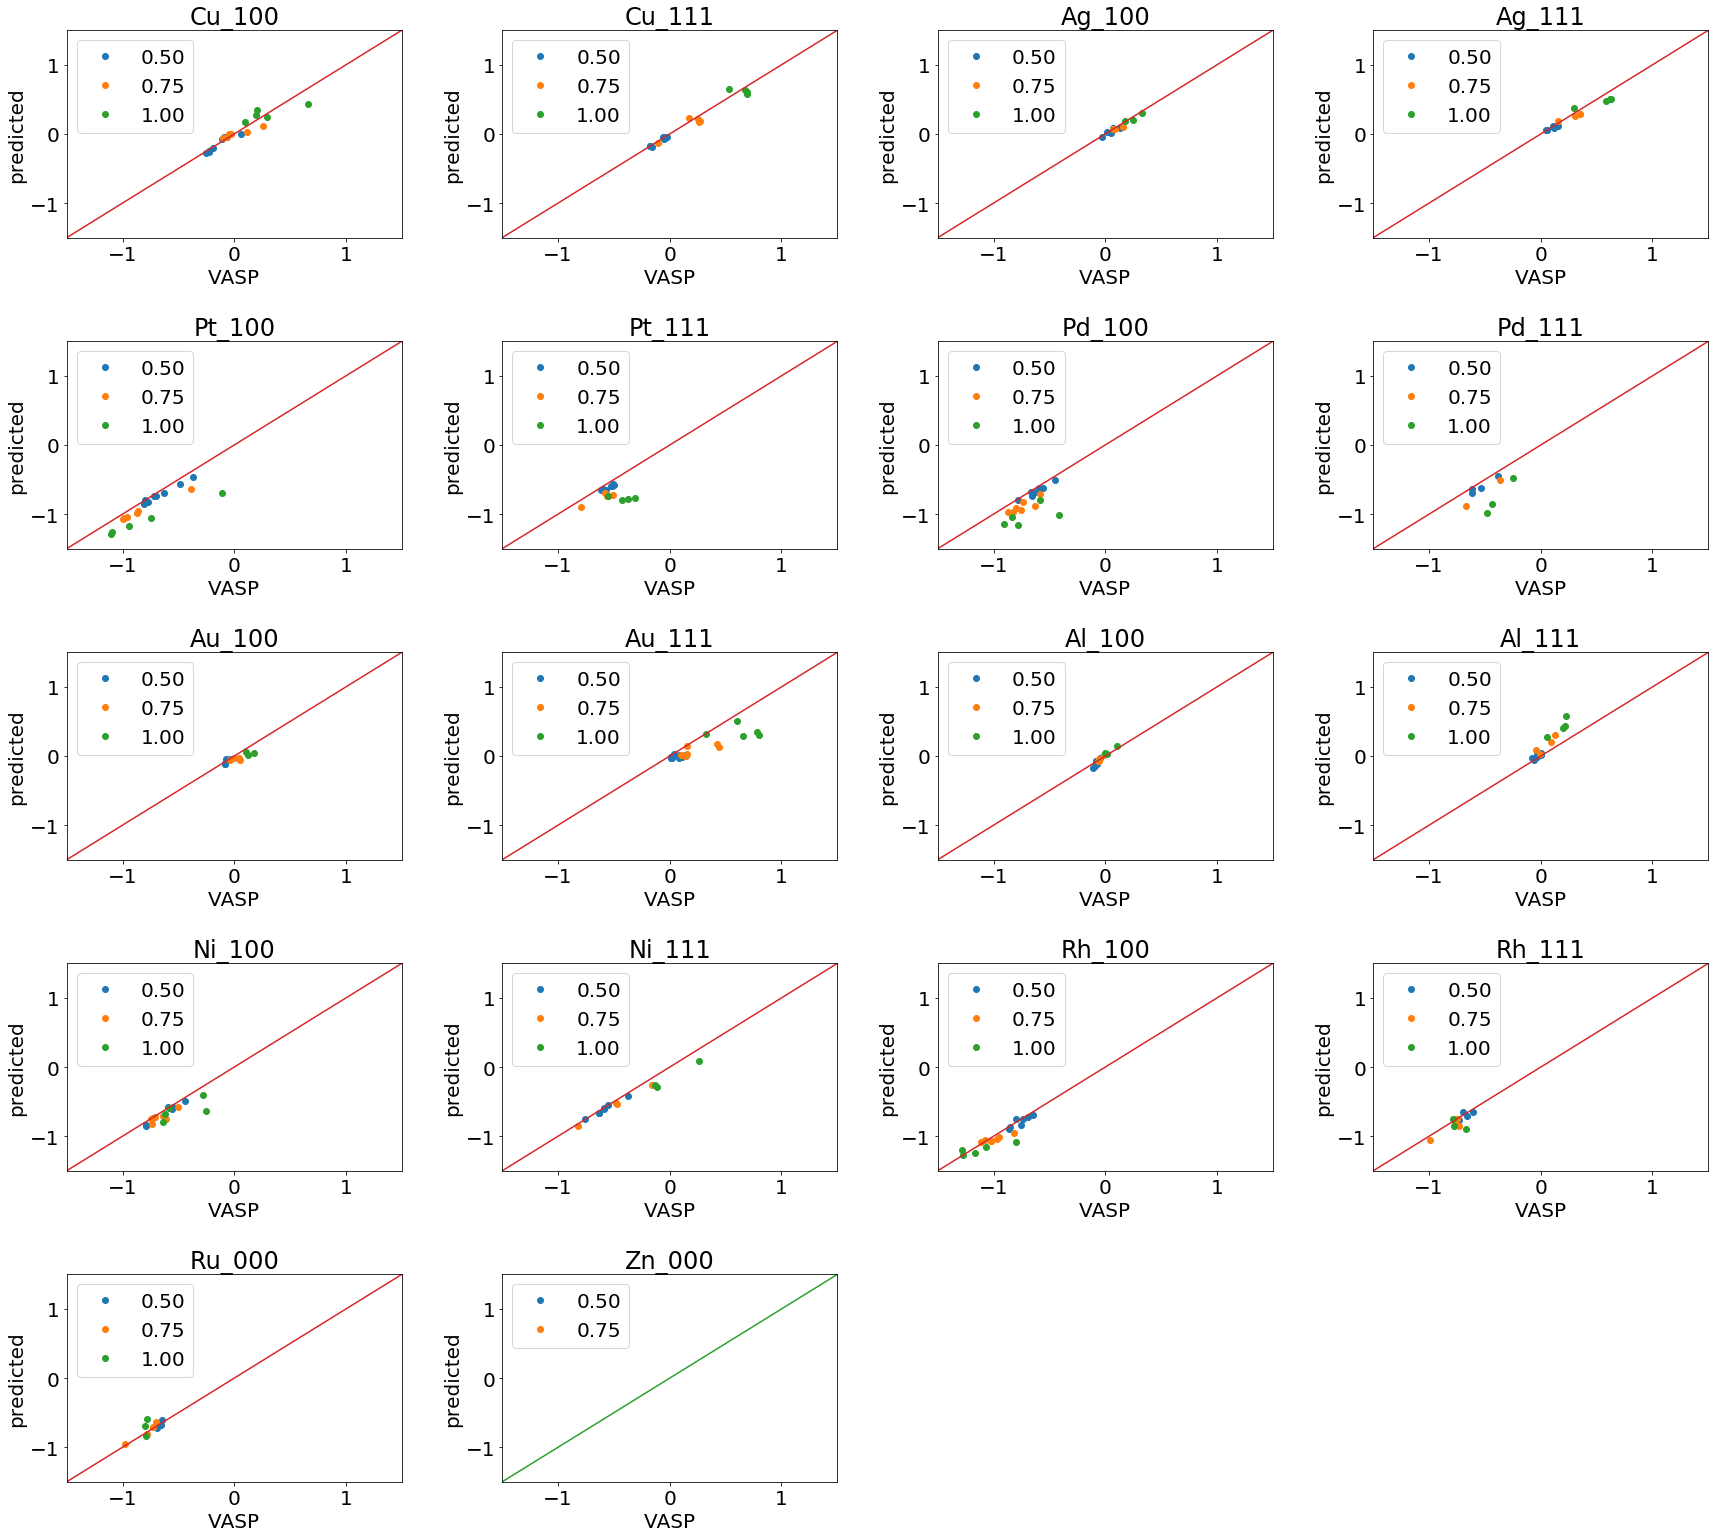

In [9]:
xrange = np.linspace(-2, 2)

fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    xmin = 100
    xmax = -100
    dfpred[i]['predE/surfatom'] = 0
    dfpred[i]['sumadsE/surfatom'] = 0
    dfpred[i]['Eint/surfatom'] = 0
    for j in range(len(dfpred[i])):
        try:
            predadsene_surf, adsElis, Eint = predE(i, dfpred[i].iloc[j], True, False)
            dfpred[i].iloc[j, -3] = predadsene_surf
            dfpred[i].iloc[j, -2] = sum(adsElis)/dfpred[i].iloc[j]['surfatomnum']
            dfpred[i].iloc[j, -1] = Eint/dfpred[i].iloc[j]['surfatomnum']
        except:
#             print('Error in finding one adsorbate result.')
            dfpred[i].iloc[j, -3] = None
            dfpred[i].iloc[j, -2] = None
            dfpred[i].iloc[j, -1] = None

    for j in range(len(covset[i])):
        predElis = list(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['predE/surfatom'])
        calcElis = list(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['aveadsEne/suratom'])
        if calcElis == []:
            continue
        if xmin > np.min(calcElis):
            xmin = np.min(calcElis)
        if xmax < np.max(calcElis):
            xmax = np.max(calcElis)
        ax.plot(calcElis, predElis, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('VASP')
    ax.set_ylabel('predicted')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
plt.show()

In [10]:
df[5]

,_id,name,element,mirror,adsorbate,unitlength,surfatomnum,area,Energy,totaladsEnergy,aveadsEne/suratom,numberofads,coverage,density,igroups,iposlis,rgroups,rposlis,ECO_Eint,COlengthlis,converged,aveadsEne/ads,moved+,moved
0,5de54244237123b6eeb97a63,Pt_111_u2.traj,Pt,111,None,2,4,27.585488,-82.920300,0.000000,0.000000,0,0.00,0.000000,[],[],[],[],0.000000,[],yes,NaN,no,no
1,5de54245237123b6eeb97a64,Pt_111_u2_no01_CO_n1_d9.traj,Pt,111,CO,2,4,27.585488,-98.728217,-1.322481,-0.330620,1,0.25,0.036251,[0],"[[0.0, 0.0, 18.762269282616817]]",[0],"[[-2.4586243209140364e-06, -2.6513049185610634...",-14.482056,[1.1635841876803108],yes,-1.322481,no,no
2,5de54246237123b6eeb97a65,Pt_111_u2_no02_CO_n2_d3.traj,Pt,111,CO,2,4,27.585488,-113.929781,-2.038609,-0.509652,2,0.50,0.072502,"[0, 0]","[[2.8219221178541876, 0.0, 18.762269282616817]...","[0, 0]","[[2.8219152767539564, 0.011336169753719805, 18...",-28.561499,"[1.1642038639029442, 1.1643748561560752]",yes,-1.019304,no,no
3,5de54247237123b6eeb97a66,Pt_111_u2_no03_CO_n3_d3.traj,Pt,111,CO,2,4,27.585488,-128.689031,-2.312422,-0.578106,3,0.75,0.108753,"[0, 0, 0]","[[1.410961058927094, 2.4438562415629113, 18.76...","[0, 0, 0]","[[1.4109750141271928, 2.4377929433655154, 18.8...",-42.228386,"[1.1641884664006843, 1.1641615756998265, 1.164...",yes,-0.770807,no,no
4,5de54248237123b6eeb97a67,Pt_111_u2_no04_CO_n4_d3.traj,Pt,111,CO,2,4,27.585488,-143.060864,-2.198819,-0.549705,4,1.00,0.145004,"[0, 0, 0, 0]","[[4.232883176781282, 2.4438562415629113, 18.76...","[0, 0, 0, 0]","[[4.232902759871253, 2.443855820773753, 18.867...",-55.537657,"[1.1644804461017866, 1.1643755897134356, 1.164...",yes,-0.549705,no,no
5,5de54249237123b6eeb97a68,Pt_111_u2_no05_CO_n2_d4.traj,Pt,111,CO,2,4,27.585488,-114.284551,-2.393379,-0.598345,2,0.50,0.072502,"[3, 0]","[[2.8219221178541876, 1.6292374943752728, 18.7...","[3, 0]","[[2.821823916737212, 1.6291825115273828, 18.28...",-28.824481,"[1.1582205806190673, 1.2053404094407532]",yes,-1.196690,no,no
6,5de54249237123b6eeb97a69,Pt_111_u2_no06_CO_n3_d4.traj,Pt,111,CO,2,4,27.585488,-129.560282,-3.183673,-0.795918,3,0.75,0.108753,"[2, 3, 0]","[[5.643844235708377, 3.258474988750548, 18.762...","[2, 3, 0]","[[5.643901993275698, 3.258507835706436, 18.404...",-42.958831,"[1.1563550602365922, 1.1948731256961482, 1.196...",yes,-1.061224,no,no
7,5de5424a237123b6eeb97a6a,Pt_111_u2_no07_CO_n2_d4.traj,Pt,111,CO,2,4,27.585488,-114.357968,-2.466795,-0.616699,2,0.50,0.072502,"[2, 0]","[[5.643844235708377, 3.258474988750548, 18.762...","[2, 0]","[[5.643915618577605, 3.2584996597909193, 18.27...",-28.824481,"[1.1587596825155284, 1.2066481539671758]",yes,-1.233398,no,no
8,5de5424b237123b6eeb97a6b,Pt_111_u2_no08_CO_n1_d9.traj,Pt,111,CO,2,4,27.585488,-98.788672,-1.382936,-0.345734,1,0.25,0.036251,[1],"[[0.7054805294635469, 1.2219281207814556, 18.7...",[1],"[[0.72402606853218, 1.2112380153831184, 18.528...",-14.482056,[1.1873911204943426],yes,-1.382936,no,no
9,5de5424c237123b6eeb97a6c,Pt_111_u2_no09_CO_n2_d3.traj,Pt,111,CO,2,4,27.585488,-113.967336,-2.076164,-0.519041,2,0.50,0.072502,"[1, 1]","[[3.527402647317733, 1.2219281207814556, 18.76...","[1, 1]","[[3.566608289566118, 1.222745069985135, 18.493...",-28.561499,"[1.1837430694973137, 1.1838195597960972]",yes,-1.038082,no,no


In [11]:
for i in range(len(dfpred)):
    dfpred[i]['VASP - prediction'] = dfpred[i]['aveadsEne/suratom'] - dfpred[i]['predE/surfatom']    

In [12]:
# 0 :Cu 100
# 1 :Cu 111
# 2 :Ag 100
# 3 :Ag 111
# 4 :Pt 100
# 5 :Pt 111
# 6 :Pd 100
# 7 :Pd 111
# 8 :Au 100
# 9 :Au 111
# 10:Al 100
# 11:Al 111
# 12:Ni 100           
# 13:Ni 111

In [13]:
ele_mir = 8

dfpred_disp = dfpred[ele_mir][['name','element','mirror','coverage','aveadsEne/suratom','predE/surfatom',\
                               'sumadsE/surfatom','Eint/surfatom','VASP - prediction']]

# pd.options.display.precision = 3
dfpred_disp.sort_values(by=['coverage']).round(3)

,name,element,mirror,coverage,aveadsEne/suratom,predE/surfatom,sumadsE/surfatom,Eint/surfatom,VASP - prediction
0,Au_100_u2_no002_CO_n2_d3.traj,Au,100,0.50,-0.034,-0.041,-0.097,0.056,0.007
5,Au_100_u2_no007_CO_n2_d6.traj,Au,100,0.50,-0.084,-0.107,-0.097,-0.011,0.023
6,Au_100_u2_no008_CO_n2_d4.traj,Au,100,0.50,-0.081,-0.110,-0.100,-0.011,0.030
8,Au_100_u2_no011_CO_n2_d3.traj,Au,100,0.50,-0.074,-0.047,-0.103,0.056,-0.027
11,Au_100_u2_no016_CO_n2_d3.traj,Au,100,0.50,0.045,-0.047,-0.103,0.056,0.092
12,Au_100_u2_no019_CO_n2_d6.traj,Au,100,0.50,-0.081,-0.113,-0.103,-0.011,0.032
1,Au_100_u2_no003_CO_n3_d3.traj,Au,100,0.75,-0.005,-0.026,-0.145,0.119,0.021
3,Au_100_u2_no005_CO_n3_d3.traj,Au,100,0.75,-0.038,-0.053,-0.148,0.095,0.015
7,Au_100_u2_no009_CO_n3_d3.traj,Au,100,0.75,0.050,-0.056,-0.151,0.095,0.105
9,Au_100_u2_no012_CO_n3_d3.traj,Au,100,0.75,0.044,-0.035,-0.154,0.119,0.079


In [14]:
id = 1
env = 'local'

name = dfpred[ele_mir].iloc[id]['name']
allname = dfpred[ele_mir].iloc[id]['name'][:-5] + '_all.traj'
# query(name, env)
# query(allname, env)

In [15]:
def __get_coordination_string_mod(nn_info):
    '''
    This helper function takes the output of the `VoronoiNN.get_nn_info` method
    and gives you a standardized coordination string.
    Arg:
        nn_info     The output of the
                    `pymatgen.analysis.local_env.VoronoiNN.get_nn_info` method.
    Returns:
        coordination    A string indicating the coordination of the site
                        you fed implicitly through the argument, e.g., 'Cu-Cu-Cu'
    '''
    coordinated_atoms = [neighbor_info['site'].species_string
                         for neighbor_info in nn_info
                         if neighbor_info['site'].species_string != 'Kr']
    coordination = '-'.join(sorted(coordinated_atoms))
    
    coordinated_indexes = [neighbor_info['site_index']
                         for neighbor_info in nn_info
                         if neighbor_info['site'].species_string != 'Kr']

    return coordination, coordinated_indexes

def get_modified_bonding_matrix(atoms):
    '''
    This function will fingerprint a slab+adsorbate atoms object for you.
    It only  with multiple adsorbates.
    Arg:
        atoms   `ase.Atoms` object to fingerprint. The slab atoms must be
                tagged with non-zero integers and adsorbate atoms must be
                tagged with zero. This function also assumes that the
                first atom in each adsorbate is the binding atom (e.g.,
                of all atoms with tag==1, the first atom is the binding;
                the same goes for tag==2 and tag==3 etc.).
    Returns:
        fingerprint A dictionary whose keys are:
                        coordination            A string indicating the
                                                first shell of
                                                coordinated atoms
                        neighborcoord           A list of strings
                                                indicating the coordination
                                                of each of the atoms in
                                                the first shell of
                                                coordinated atoms
                        nextnearestcoordination A string identifying the
                                                coordination of the
                                                adsorbate when using a
                                                loose tolerance for
                                                identifying "neighbors"
    '''
    # Replace the adsorbate[s] with a single Krypton atom at the first binding
    # site. We need the Krypton there so that pymatgen can find its
    # coordination.  
    atoms, binding_positions = removemolecule(atoms, 'CO')
    nads = len(binding_positions)
    for i in reversed(range(nads)):
        atoms += Atoms('Kr', positions=[binding_positions[i]])
    b_mat = np.zeros([len(atoms), len(atoms)])
    Krypton_indexes = []
    for atom in atoms:
        if atom.symbol == 'Kr':
            Krypton_indexes.append(atom.index)
    struct = AseAtomsAdaptor.get_structure(atoms)
    
    try:
        for atom in atoms:
            # We have a standard and a loose Voronoi neighbor finder for various
            # purposes
            vnn = VoronoiNN(allow_pathological=True, tol=0.6, cutoff=10) # originally tol=0.8
            vnn_loose = VoronoiNN(allow_pathological=True, tol=0.2, cutoff=10)

            # Find the coordination
            if atom.symbol == 'Kr':
                nn_info = vnn.get_nn_info(struct, n=atom.index)
                coordination, cindexes = __get_coordination_string_mod(nn_info)
            else:
                nn_info = vnn_loose.get_nn_info(struct, n=atom.index)
                coordination, cindexes = __get_coordination_string_mod(nn_info)
            for cindex in cindexes:
                b_mat[atom.index][cindex] = 1/len(cindexes)
                b_mat[cindex][atom.index] = 1/len(cindexes)
            
        return b_mat, nads
        
    # If we get some QHull or ValueError, then just assume that the adsorbate desorbed
    except (QhullError, ValueError):
        return None
    
def get_number_matrix(b_mat, nads, repeat):
#     b_matlis = []
#     sumb_matlis = []
    newb_mat = copy.deepcopy(b_mat)
#     sumb_mat = 0
    done = np.zeros([nads//repeat**2])
    results = []
    i = 2
    while True:
        newb_mat = newb_mat @ b_mat
#         b_matlis.append(newb_mat)
#         sumb_mat = sumb_mat + newb_mat
#         sumb_matlis.append(sumb_mat)
        newb_matCO = (newb_mat - np.diag(np.diag(newb_mat)))[-nads:,-nads:] # extract related adsorbate and non-diagonal terms
        newb_matCO = newb_matCO[nads//repeat**2*4:nads//repeat**2*5] # examinimg only center one is sufficient

        for j in range(nads//repeat**2):
            if done[j] == 0:
                if not (newb_matCO[j] == 0).all():
                    done[j] = 1
                    nnearestbonding = np.max(np.sum(newb_matCO[j:nads:nads//repeat**2,:], axis=1))
#                     print('adsorbate {} has {} nearest adsorbate at {}th neighbor'.format(j,nnearestbonding,i))
#                     print(newb_matCO[j:nads:nads//repeat**2,:])
                    results.append([j,i,nnearestbonding])
                
#         print('')
        i += 1
#         if (done == 1).all() or i==6:
#             break
        if i==4:
            break

    return np.array(results) # [adsorbate_index, distance, # of nearest adsorbate]

In [16]:
for i in range(len(dfpred)):
    dfpred[i]['#nbads'] = 0 # nearest bonding distance
    dfpred[i]['nbdist'] = 0 # nearest bonding distance    
    for j in range(len(dfpred[i])):
        name = dfpred[i].iloc[j]['name']
        atoms = query(name)
        repeat = 3 # repeat
        ratoms = get_repeated_atoms(atoms, repeat)

        b_mat, nads = get_modified_bonding_matrix(ratoms)
        results = get_number_matrix(b_mat, nads, repeat)
        try:
            nbdist = np.min(results[:,1])
            nnbads = 0
            for item in results:
                nnbads += item[2]
            print(name, nbdist, nnbads)
            dfpred[i].iloc[j, -2] = nnbads
            dfpred[i].iloc[j, -1] = nbdist
        except:
            print('Error')

Cu_100_u2_no02_CO_n2_d3.traj 3.0 0.5
Cu_100_u2_no03_CO_n3_d3.traj 3.0 1.0
Cu_100_u2_no04_CO_n4_d3.traj 3.0 2.0
Cu_100_u2_no05_CO_n3_d3.traj 3.0 1.0625
Cu_100_u2_no06_CO_n4_d3.traj 2.0 2.0
Error
Cu_100_u2_no08_CO_n2_d3.traj 3.0 0.3125
Cu_100_u2_no09_CO_n3_d3.traj 2.0 1.25
Cu_100_u2_no11_CO_n2_d3.traj 3.0 0.375
Cu_100_u2_no13_CO_n4_d3.traj 2.0 2.0
Cu_100_u2_no14_CO_n3_d3.traj 2.0 1.0
Cu_100_u2_no15_CO_n4_d3.traj 2.0 2.5
Cu_100_u2_no16_CO_n2_d5.traj 3.0 0.375
Cu_100_u2_no18_CO_n3_d3.traj 2.0 1.5
Cu_100_u2_no19_CO_n2_d3.traj 2.0 1.0
Cu_100_u2_no21_CO_n2_d3.traj 2.0 0.5
Cu_100_u2_no22_CO_n3_d3.traj 2.0 1.5
Cu_100_u2_no23_CO_n4_d3.traj 2.0 3.0
Cu_100_u2_no24_CO_n2_d5.traj 2.0 0.5
Cu_111_u2_no02_CO_n2_d3.traj 3.0 0.4444444444444444
Cu_111_u2_no03_CO_n3_d3.traj 3.0 1.3333333333333333


KeyboardInterrupt: 

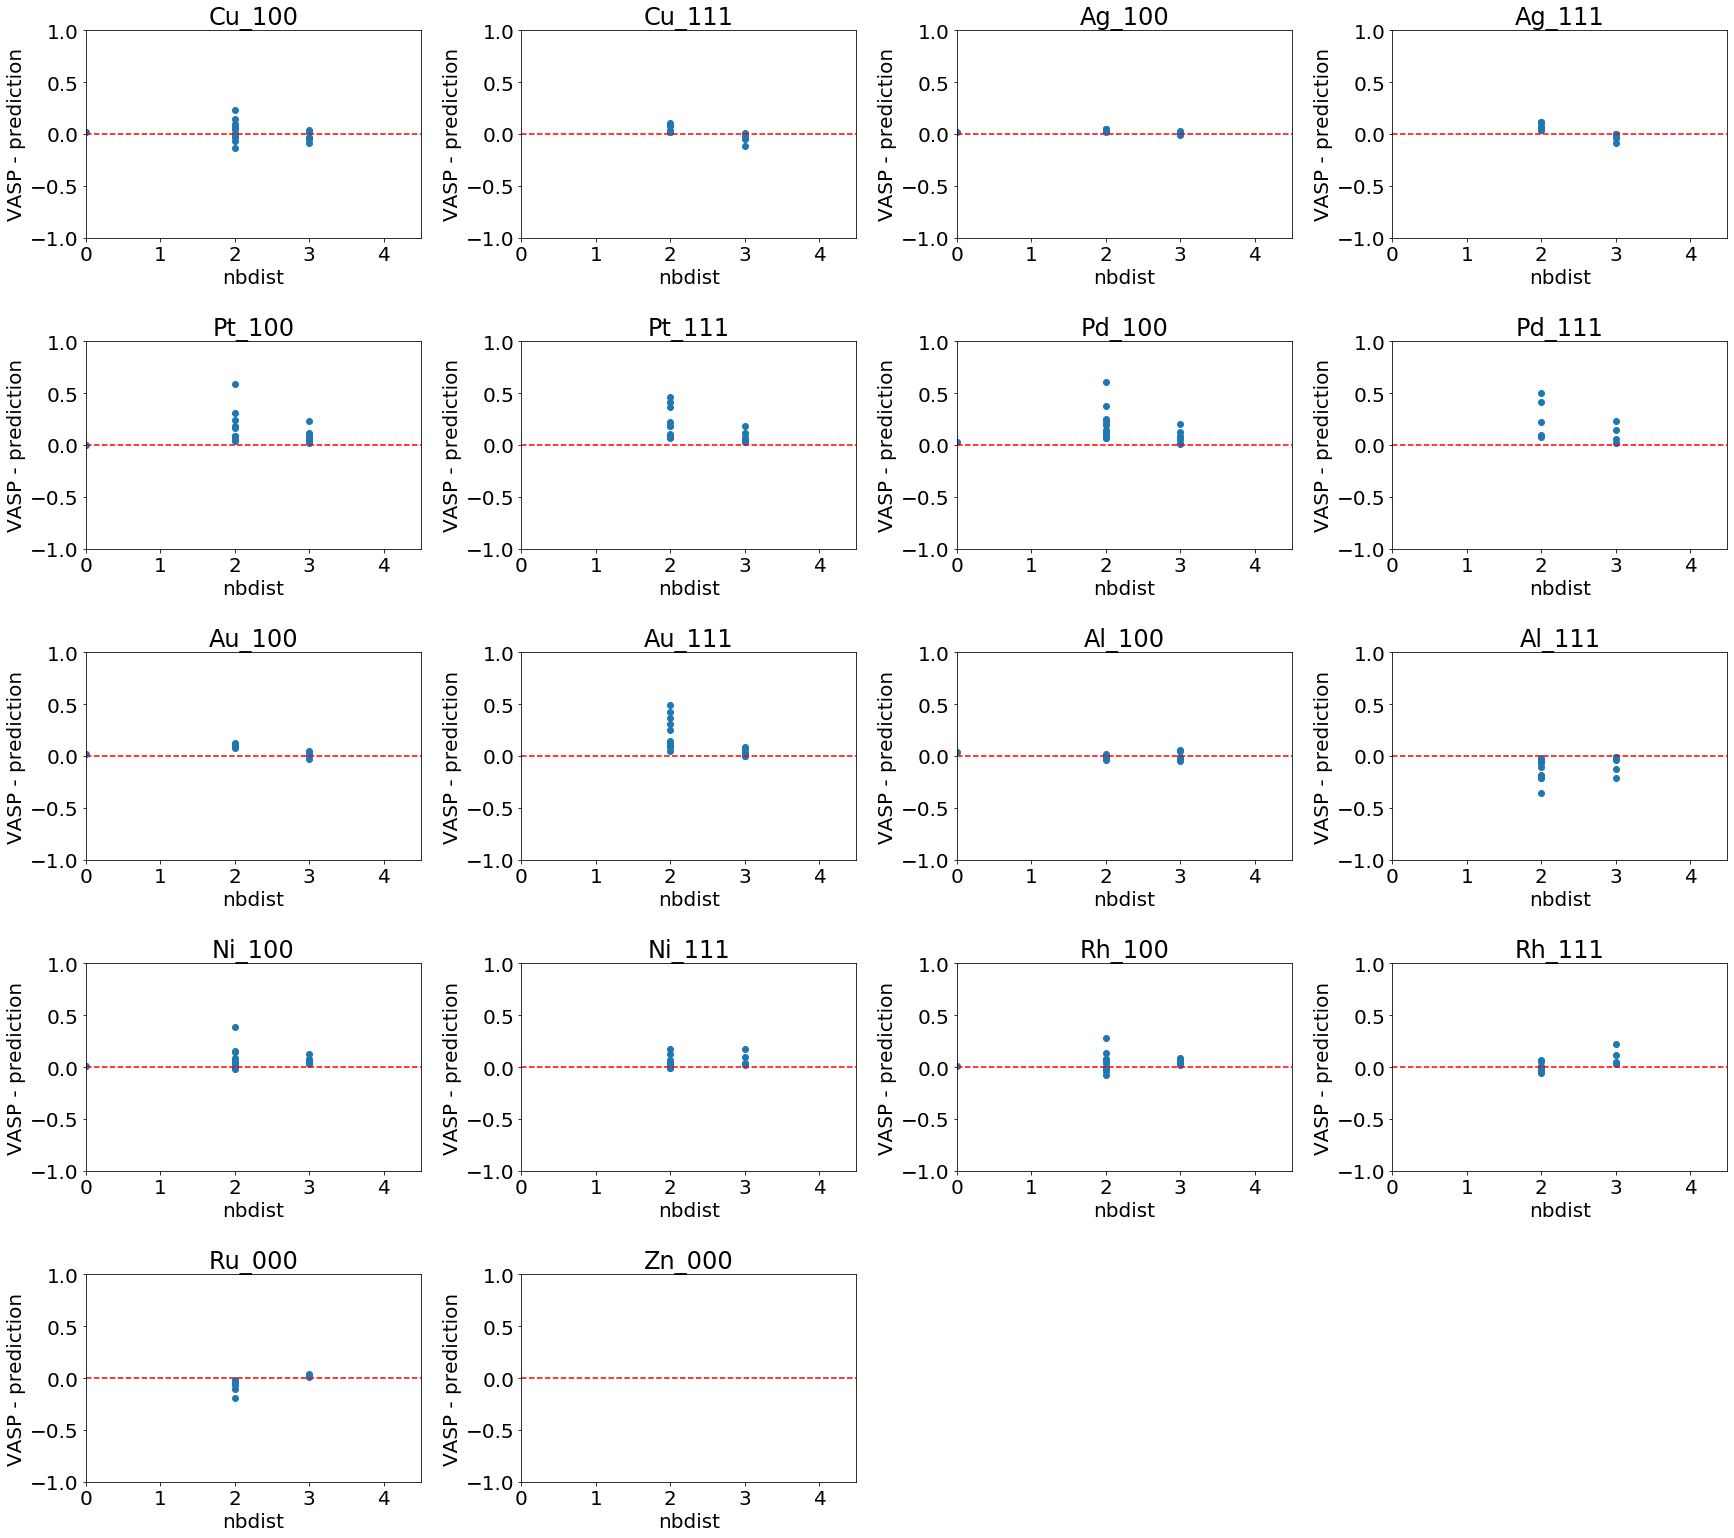

In [17]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

xmin = 0
xmax = 4.5
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(dfpred[i]['nbdist'], dfpred[i]['VASP - prediction'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way

    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('nbdist')
    ax.set_ylabel('VASP - prediction')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

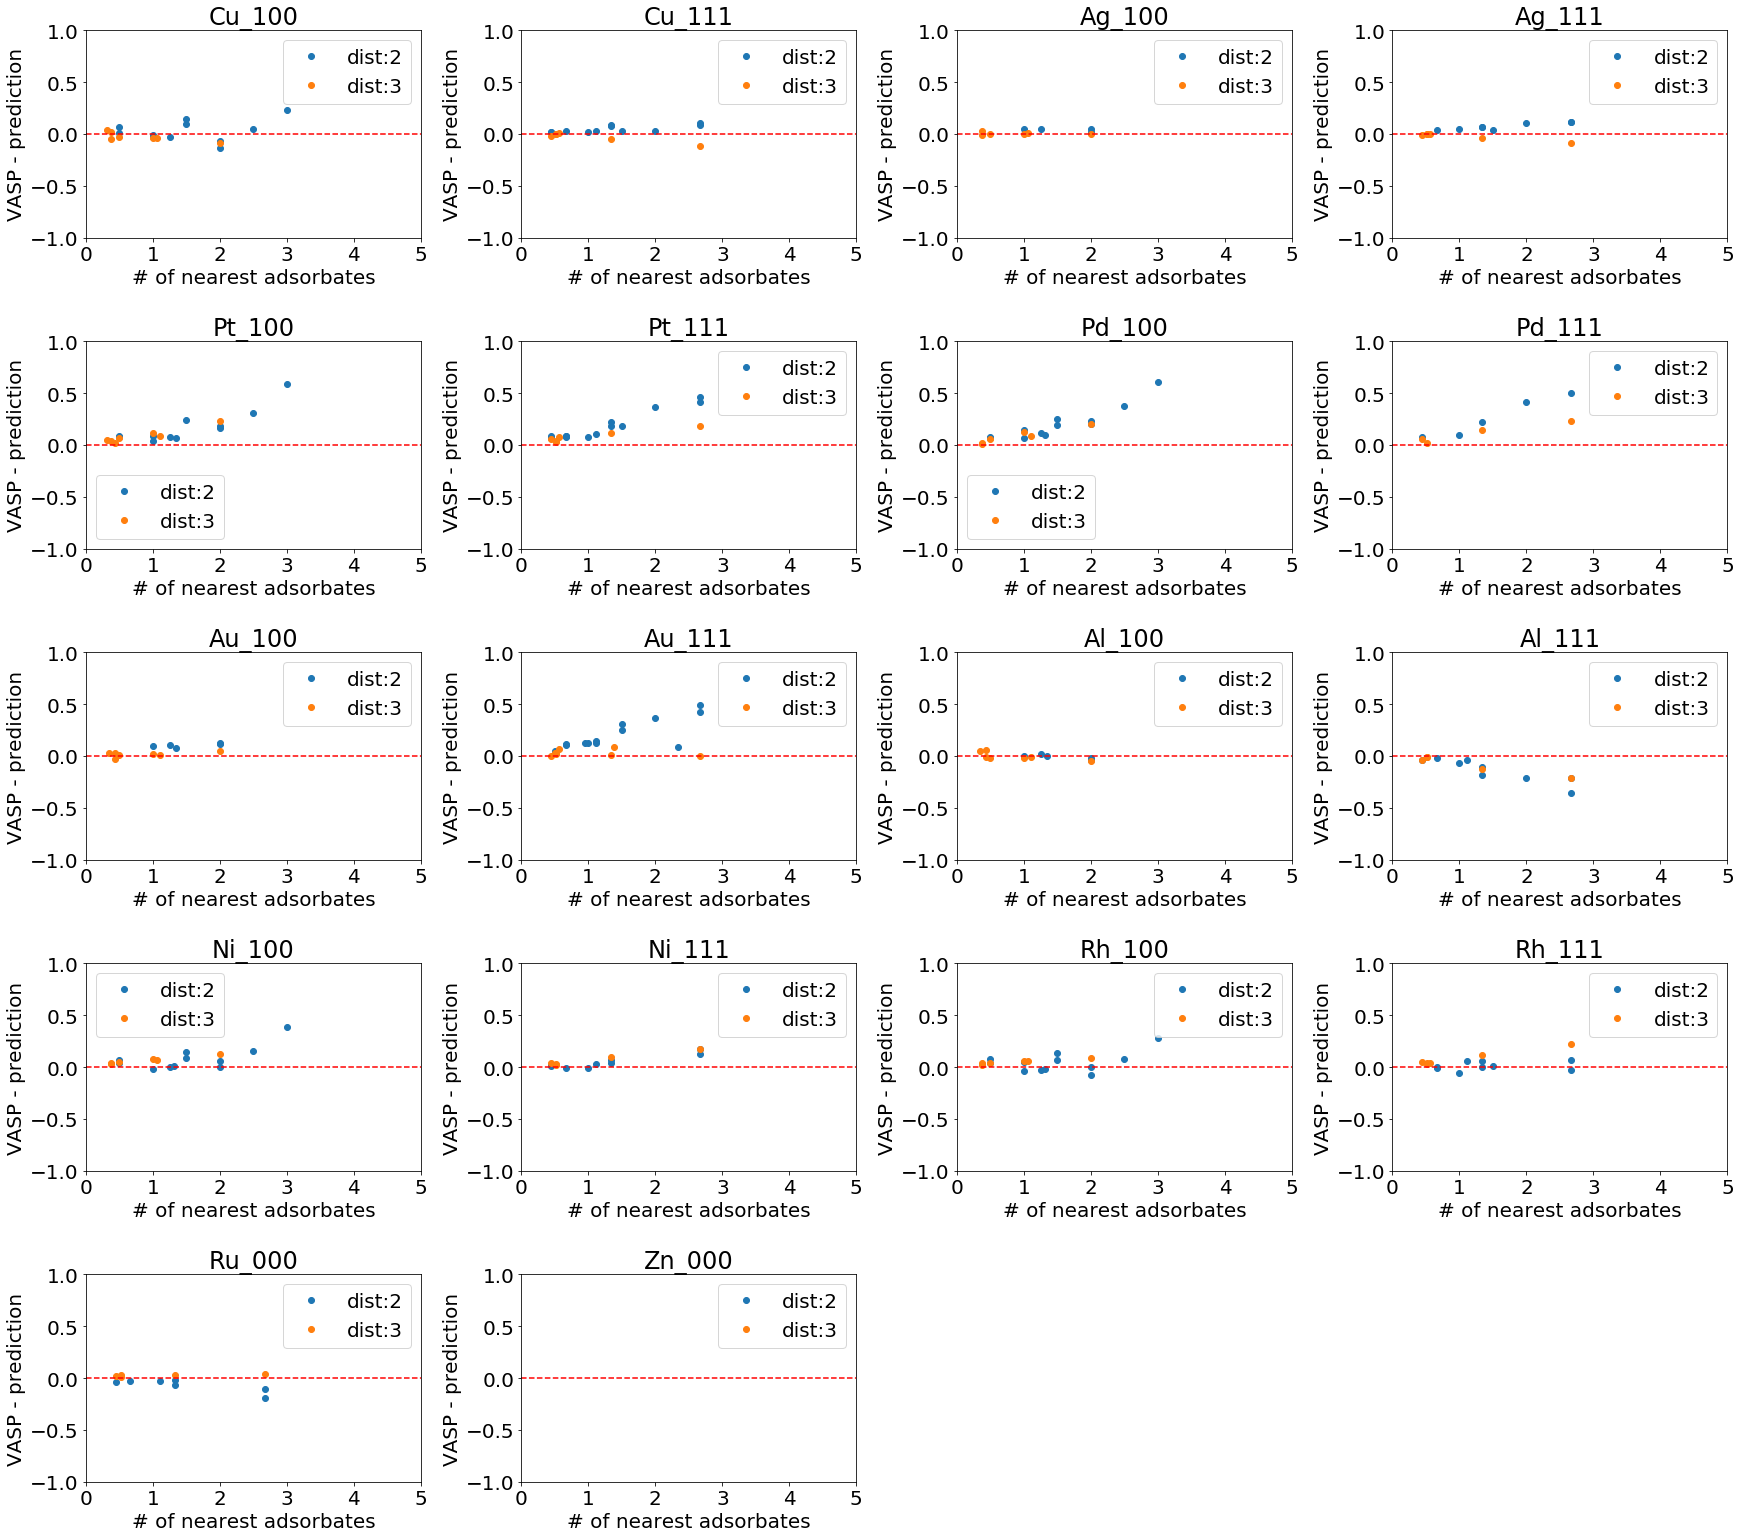

In [18]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

xmin = 0
xmax = 5
# nbdist = 2
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(dfpred[i][dfpred[i]['nbdist']==2]['#nbads'], dfpred[i][dfpred[i]['nbdist']==2]['VASP - prediction'], 'o')
    ax.plot(dfpred[i][dfpred[i]['nbdist']==3]['#nbads'], dfpred[i][dfpred[i]['nbdist']==3]['VASP - prediction'], 'o')
#     ax.plot(dfpred[i][dfpred[i]['nbdist']==4]['#nbads'], dfpred[i][dfpred[i]['nbdist']==4]['VASP - prediction'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('VASP - prediction')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:2','dist:3'])
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

In [ ]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

xmin = 0
xmax = 5
# nbdist = 2
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(dfpred[i][dfpred[i]['nbdist']==2]['#nbads'], dfpred[i][dfpred[i]['nbdist']==2]['VASP - prediction'], 'o',color='C0')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('VASP - prediction')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:2'])
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

In [ ]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

xmin = 0
xmax = 5
# nbdist = 2
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(dfpred[i][dfpred[i]['nbdist']==3]['#nbads'], dfpred[i][dfpred[i]['nbdist']==3]['VASP - prediction'], 'o',color='orange')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('VASP - prediction')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:3'])
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()